## APAN5420 Anomaly Detection - Assignment 7


## Data

* The Medicare Inpatient Hospitals by Geography and Service dataset provides information on hospital discharges for Original Medicare Part A beneficiaries by IPPS hospitals. This dataset contains information on the number of discharges, payments, and submitted charges organized by geography and Medicare Severity Diagnosis Related Group (DRG).

## Table of Contents
* [Section 1: Data preparation](#Section_1)
    * [Section 1.1: Load data](#Section_11)
    * [Section 1.2: data preparation](#Section_12)
* [Section 2: EDA](#Section_2)
    * [Section 2.1: Distribution plots](#Section_21)
    * [Section 2.2: Count by state](#Section_22)    
    * [Section 2.3: Count of top cities](#Section_23)
    * [Section 2.4: Correlation Matrix](#Section_24)
* [Section 3: Feature engineering](#Section_3)
    * [Section 3.1: State & DRG Total Payment average](#Section_31)
    * [Section 3.2: City & DRG Total Payment average](#Section_32)
    * [Section 3.3: Region & DRG Total Payment average](#Section_33)
    * [Section 3.4: State & DRG Total Discharges average](#Section_34)
    * [Section 3.5: City & DRG Total Discharges average](#Section_35)
    * [Section 3.6: Region & DRG Total Discharges average](#Section_36)
    * [Section 3.7: State & DRG Medicare Payments average](#Section_37) 
    * [Section 3.8: City & DRG Medicare Payments average](#Section_38)
    * [Section 3.9: Region & DRG Medicare Payments average](#Section_39)
    * [Section 3.10: Zipcode & DRG Medicare Payments average](#Section_40)
* [Section 4: Python Outlier Detection (PyOD) Autoencoder](#Section_4)
* [Section 5: Python Outlier Detection (PyOD) Isolation Forest](#Section_5)

## Section 1: Data preparation <a class="anchor" id="Section_1"></a>
### Section 1.1: Load Data <a class="anchor" id="Section_11"></a>
* Import packages and data 
* Rename column
* Change data type and transfer spending amount with dollar sign into numeric
* Understand the data strcuture. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('inpatientCharges.csv')

In [3]:
df.describe()

,Provider Id,Provider Zip Code,Total Discharges
count,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304
std,151563.671767,27854.323080,51.104042
min,10001.000000,1040.000000,11.000000
25%,110092.000000,27261.000000,17.000000
50%,250007.000000,44309.000000,27.000000
75%,380075.000000,72901.000000,49.000000
max,670077.000000,99835.000000,3383.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

In [5]:
df.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']
df = df.drop('Average_Covered_Charges',axis=1)

In [6]:
df.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$5658.33,$4851.44


In [7]:
# Distribution plots of average total payments 
df['Average_Total_Payments'].describe()

count       163065
unique      147842
top       $4370.00
freq             9
Name: Average_Total_Payments, dtype: object

In [8]:
# Change data type and transfer spending amount with dollar sign into numeric
df['DRG'] = df['DRG'].astype('category')
df['Provider_State'] = df['Provider_State'].astype('category')
df['Provider_City'] = df['Provider_City'].astype('category')
df['Provider_Id'] = df['Provider_Id'].astype('category')
df['Average_Total_Payments'] = (df['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
df['Average_Medicare_Payment'] = (df['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

/var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/ipykernel_49184/976114077.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Average_Total_Payments'] = (df['Average_Total_Payments']
/var/folders/4q/w1lktl152hx0j0gq933rclnh0000gn/T/ipykernel_49184/976114077.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Average_Medicare_Payment'] = (df['Average_Medicare_Payment']


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   DRG                            163065 non-null  category
 1   Provider_Id                    163065 non-null  category
 2   Provider_Name                  163065 non-null  object  
 3   Provider_StreetAddress         163065 non-null  object  
 4   Provider_City                  163065 non-null  category
 5   Provider_State                 163065 non-null  category
 6   Provider_Zipcode               163065 non-null  int64   
 7   Hospital_referral_region_desp  163065 non-null  object  
 8   Total_Discharges               163065 non-null  int64   
 9   Average_Total_Payments         163065 non-null  float64 
 10  Average_Medicare_Payment       163065 non-null  float64 
dtypes: category(4), float64(2), int64(2), object(3)
memory usage: 9.9+ MB


## Section 2: EDA <a class="anchor" id="Section_2"></a>

### Section 2.1: Distribution plots <a class="anchor" id="Section_21"></a>

In [10]:
# Distribution plots of average total payments 
df['Average_Total_Payments'].describe()

count    163065.000000
mean       9707.473804
std        7664.642598
min        2673.000000
25%        5234.500000
50%        7214.100000
75%       11286.400000
max      156158.180000
Name: Average_Total_Payments, dtype: float64

<AxesSubplot:xlabel='Average_Total_Payments', ylabel='Count'>

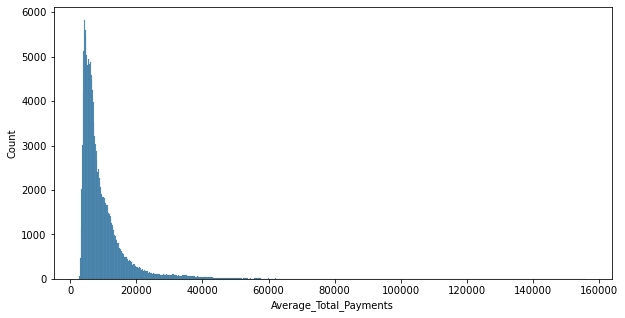

In [11]:
plt.figure(figsize=(10,5)) # Plot a graph with reasonable size.
sns.histplot(df['Average_Total_Payments'])
# plt.plot(data['Average_Total_Payments'])

<AxesSubplot:xlabel='Average_Total_Payments'>

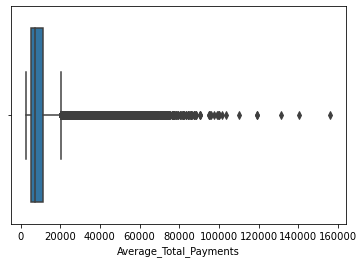

In [12]:
sns.boxplot(x = 'Average_Total_Payments', data = df) 

In [13]:
# Distribution plots of Total_Discharges
df['Total_Discharges'].describe()

count    163065.000000
mean         42.776304
std          51.104042
min          11.000000
25%          17.000000
50%          27.000000
75%          49.000000
max        3383.000000
Name: Total_Discharges, dtype: float64

<AxesSubplot:xlabel='Total_Discharges', ylabel='Count'>

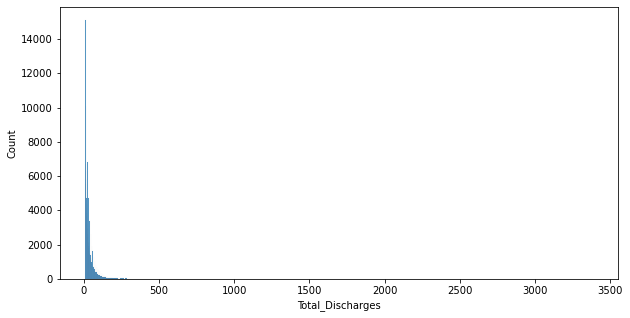

In [14]:
plt.figure(figsize=(10,5)) 
sns.histplot(df['Total_Discharges'])

<AxesSubplot:xlabel='Total_Discharges'>

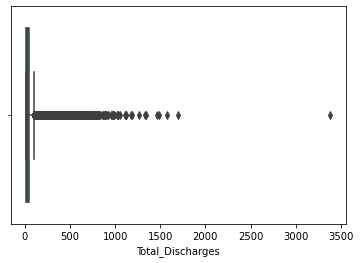

In [15]:
sns.boxplot(x = 'Total_Discharges', data = df)

In [16]:
# Distribution plots of Average_Medicare_Payment
df['Average_Medicare_Payment'].describe()

count    163065.000000
mean       8494.490964
std        7309.467261
min        1148.900000
25%        4192.350000
50%        6158.460000
75%       10056.880000
max      154620.810000
Name: Average_Medicare_Payment, dtype: float64

<AxesSubplot:xlabel='Average_Medicare_Payment', ylabel='Count'>

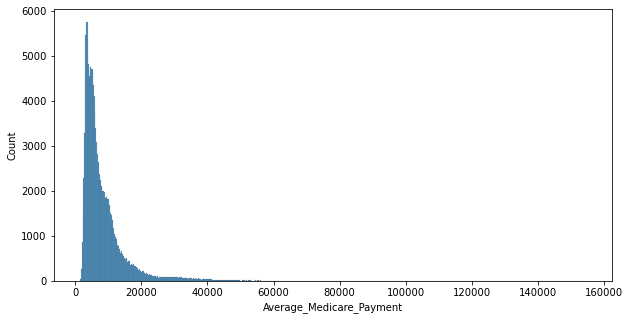

In [17]:
plt.figure(figsize=(10,5)) 
sns.histplot(df['Average_Medicare_Payment'])

<AxesSubplot:xlabel='Average_Medicare_Payment'>

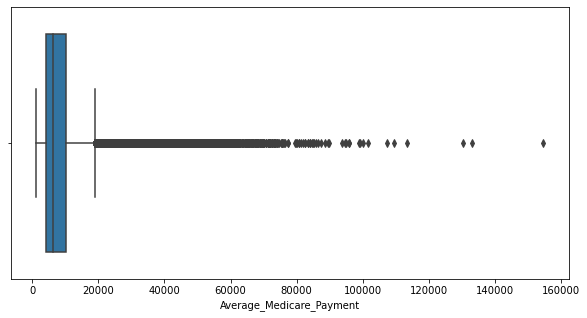

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Average_Medicare_Payment', data = df)

* We find that most of the all of the discharges are over and mosty less that 50.
* We also find that the average total payment and average medicare payment follow similar pattern, mostly less than 10,000 dollars but significant number of outliers upto 156,158 dollars.

### Section 2.2: Count by State <a class="anchor" id="Section_22"></a>

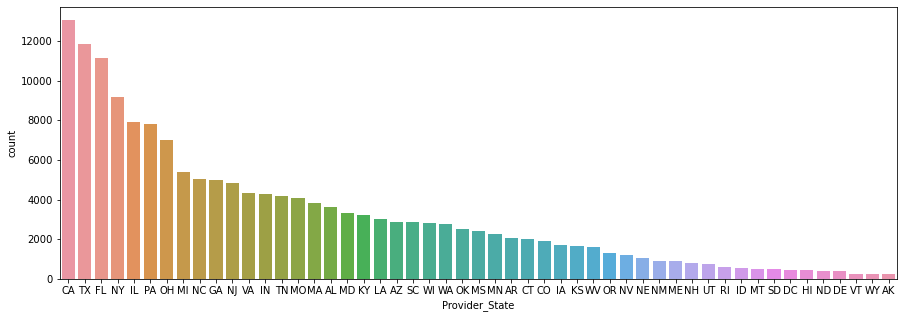

In [19]:
# data['Provider_State'].value_counts()
plt.figure(figsize=(15,5))
sns.countplot(x='Provider_State',data=df,order=df['Provider_State'].value_counts().index)
#plt.xticks(rotation = 90)
#ax = plt.gca()
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
#            fontsize=12, color='blue', ha='center', va='bottom')
plt.rcParams["axes.labelsize"] = 20

* From this histogram, California, Texas, and Florid has the highest number of hospital divisions.

### Section 2.3: Count of top 20 cities <a class="anchor" id="Section_23"></a>

In [20]:
df['Provider_Name'].value_counts()

GOOD SAMARITAN HOSPITAL                  633
ST JOSEPH MEDICAL CENTER                 427
MERCY MEDICAL CENTER                     357
MERCY HOSPITAL                           347
ST JOSEPH HOSPITAL                       343
                                        ... 
J PAUL JONES HOSPITAL                      1
GREATER BATON ROUGE SURGICAL HOSPITAL      1
FAIRWAY MEDICAL CENTER                     1
MONROE SURGICAL HOSPITAL                   1
EAGLEVILLE HOSPITAL                        1
Name: Provider_Name, Length: 3201, dtype: int64

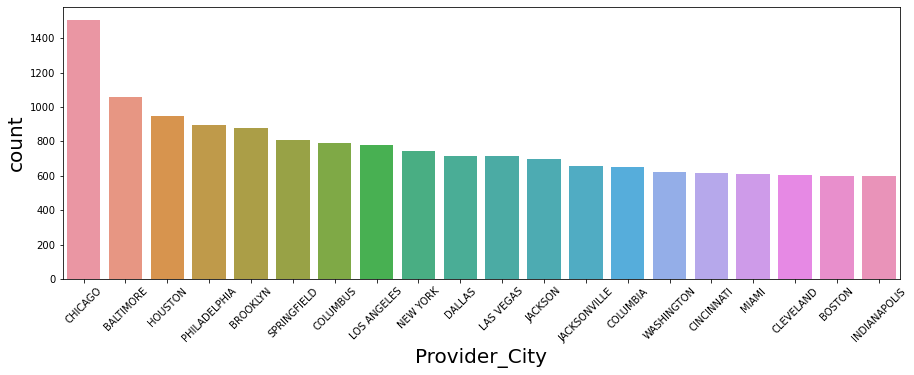

In [21]:
plt.figure(figsize=(15,5))
txt = df['Provider_City'].value_counts()[:20].index

chart = sns.countplot(
    x='Provider_City' ,data=df , order=txt
)

_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.rcParams["axes.labelsize"] = 10

* Even though the number of hospital divisions in State Illinois and State Maryland are not ranking top in the State group bys, their hospital divisions rank the most when looking at the city group bys (Chicago and Baltimore).

#### Thought process:
- The following shows the average medicare payment by DRG. Does it make sense to compare "917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC" with "885 - PSYCHOSES"?

In [22]:
df.groupby('DRG')['Average_Total_Payments'].describe().reset_index()

,DRG,count,mean,std,min,25%,50%,75%,max
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,1079.0,6960.534004,1477.873952,4968.00,6001.8300,6582.890,7516.825,18420.56
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,1201.0,6706.276445,2033.965862,4194.09,5412.8700,6093.750,7345.360,25519.43
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1659.0,13263.823032,3847.918207,8174.28,10762.2200,12084.700,14424.325,50882.40
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,2269.0,7922.671141,2084.658336,5368.73,6626.2700,7280.050,8503.060,26510.15
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,1806.0,5713.985221,1342.538675,3916.41,4819.3250,5326.025,6197.480,14744.05
...,...,...,...,...,...,...,...,...,...
95,885 - PSYCHOSES,613.0,6968.721876,2440.280958,4444.90,5477.2400,6155.560,7841.280,32200.77
96,897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REH...,906.0,4949.907307,1462.463278,3172.44,3969.9675,4529.535,5440.675,18630.92
97,917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC,843.0,10763.814413,2823.004637,6942.83,8851.4550,10062.280,11788.675,33251.14
98,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,1382.0,4485.378734,1154.328951,3040.72,3720.5725,4136.105,4879.390,12479.80


In [23]:
# Distribution plots of average total payments 
df['Total_Discharges'].describe()

count    163065.000000
mean         42.776304
std          51.104042
min          11.000000
25%          17.000000
50%          27.000000
75%          49.000000
max        3383.000000
Name: Total_Discharges, dtype: float64

### Section 2.4: Correlation Matrix <a class="anchor" id="Section_24"></a>
* To examine the correlation between the variables and find that the charges a highly correlated.

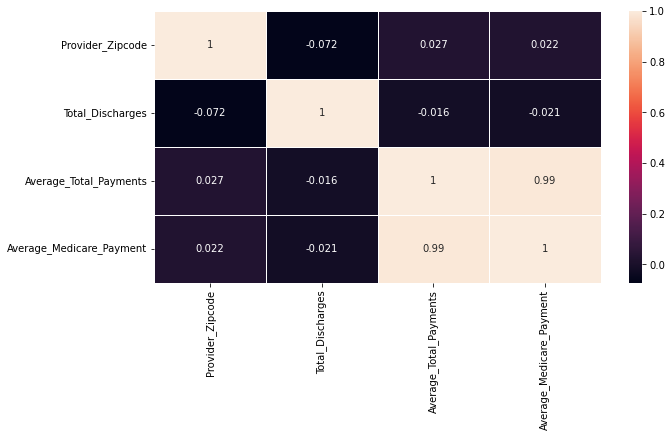

In [24]:
corr_matrix = df.corr()
ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.show()

## Section 3: Feature Engineering <a class="anchor" id="Section_3"></a>

### Section 3.1: State & DRG Total Payment average <a class="anchor" id="Section_31"></a>
- Calculating average ratio of Average Total Payment of every Provider state in DRG description. This will help understand the average total payment comparisons within the state in each DRG category. 

In [25]:
benchmark = df.groupby(['Provider_State','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Avg_Payment_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8401.950000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8799.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21608.010000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,12555.548333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,9275.867500


In [26]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df, benchmark, how='left', on=['Provider_State','DRG'])
# Feature 1: ratio of amount spending and average spending by drg in a state
df1['Avg_Payment_ByStateDRG_ratio_amount'] = np.where(df1['Avg_Payment_ByStateDRG']==0,0, df1['Average_Total_Payments'] / df1['Avg_Payment_ByStateDRG'])
df1['Avg_Payment_ByStateDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.195274
min           0.384805
25%           0.880824
50%           0.956830
75%           1.064688
max           7.857934
Name: Avg_Payment_ByStateDRG_ratio_amount, dtype: float64

In [27]:
len(df1[df1['Avg_Payment_ByStateDRG_ratio_amount']>2]['Provider_Name'].unique())

124

In [28]:
df1[df1['Avg_Payment_ByStateDRG_ratio_amount']>7].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,Avg_Payment_ByStateDRG_ratio_amount
20388,189 - PULMONARY EDEMA & RESPIRATORY FAILURE,390096,ST JOSEPH MEDICAL CENTER,2500 BERNVILLE ROAD,READING,PA,19605,PA - Reading,143,72797.93,7718.09,9264.257684,7.857934
38923,203 - BRONCHITIS & ASTHMA W/O CC/MCC,220008,STURDY MEMORIAL HOSPITAL,211 PARK STREET,ATTLEBORO,MA,2703,RI - Providence,11,41482.09,1790.18,5711.287429,7.263177


### Section 3.2: City & DRG Total Payment average <a class="anchor" id="Section_32"></a>
- Calculating average ratio of Average Total Payment of every Provider city in DRG description. This will help understand the average total payment comparisons within the city. 

In [29]:
benchmark = df.groupby(['Provider_City','DRG'])['Average_Total_Payments'].median().reset_index()
benchmark.columns = ['Provider_City','DRG','Average_Payment_ByCityDRG']
benchmark.head()

,Provider_City,DRG,Average_Payment_ByCityDRG
0,ABBEVILLE,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,NaN
1,ABBEVILLE,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,NaN
2,ABBEVILLE,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
3,ABBEVILLE,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
4,ABBEVILLE,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN


In [30]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_City','DRG'])
# Feature 3: ratio of amount spending and average spending by drg in a city
df1['Average_Payment_ByCityDRG_ratio_amount'] = np.where(df1['Average_Payment_ByCityDRG']==0,0, df1['Average_Total_Payments'] / df1['Average_Payment_ByCityDRG'])
df1['Average_Payment_ByCityDRG_ratio_amount'].describe()

count    163065.000000
mean          1.011287
std           0.120431
min           0.238195
25%           1.000000
50%           1.000000
75%           1.000000
max           5.591943
Name: Average_Payment_ByCityDRG_ratio_amount, dtype: float64

In [31]:
len(df1[df1['Average_Payment_ByCityDRG_ratio_amount']>2]['Provider_Name'].unique())

58

In [32]:
df1[df1['Average_Payment_ByCityDRG_ratio_amount']>5].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG,Average_Payment_ByCityDRG_ratio_amount
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.0,8374.755758,4.950409,7413.965,5.591943


### Section 3.3: Region & DRG Total Payment average <a class="anchor" id="Section_33"></a>
- Calculating average ratio of Average Total Payment of every Hospital referral region desp in DRG description. This will help understand the average total payment comparisons within the region. 

In [33]:
benchmark = df.groupby(['Hospital_referral_region_desp','DRG'])['Average_Total_Payments'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Payment_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Avg_Payment_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8401.950000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8799.000000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21608.010000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,12555.548333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,9275.867500


In [34]:
# add the new feature average spending to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# Feature 3: ratio of amount spending and average spending by drg in a region 
df1['Avg_Payment_ByRegionDRG_ratio_amount'] = np.where(df1['Avg_Payment_ByRegionDRG']==0,0, df1['Average_Total_Payments'] / df1['Avg_Payment_ByRegionDRG'])
df1['Avg_Payment_ByRegionDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.159145
min           0.271255
25%           0.902856
50%           0.977701
75%           1.057561
max           4.848303
Name: Avg_Payment_ByRegionDRG_ratio_amount, dtype: float64

In [35]:
len(df1[df1['Avg_Payment_ByRegionDRG_ratio_amount']>2]['Provider_Name'].unique())

64

In [36]:
df1[df1['Avg_Payment_ByRegionDRG_ratio_amount']>4].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG,Avg_Payment_ByRegionDRG_ratio_amount
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,37236.0,8374.755758,4.950409,7413.965,5.591943,9473.928889,4.376059
162713,948 - SIGNS & SYMPTOMS W/O MCC,390312,CANCER TREATMENT CENTERS OF AMERICA,1331 EAST WYOMING AVENUE,PHILADELPHIA,PA,19124,PA - Philadelphia,24,28968.20,8894.2,5018.809241,5.771927,6071.325,4.771314,5974.915484,4.848303


### Section 3.4: State & DRG Total Discharges average <a class="anchor" id="Section_34"></a>
- Calculating average ratio of total discharges of every Provider state in DRG description. This will help understand the total discharges comparisons within the state. 

In [37]:
benchmark = df.groupby(['Provider_State','DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Discharges_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Avg_Discharges_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23.000000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11.000000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,22.500000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,25.333333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21.000000


In [38]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_State','DRG'])
# Feature 4: ratio of amount total discharges and average total discharges by drg in a state 
df1['Avg_Discharges_ByStateDRG_ratio_amount'] = np.where(df1['Avg_Discharges_ByStateDRG']==0,0, df1['Total_Discharges'] / df1['Avg_Discharges_ByStateDRG'])
df1['Avg_Discharges_ByStateDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.686087
min           0.045025
25%           0.550452
50%           0.819820
75%           1.251471
max          24.624593
Name: Avg_Discharges_ByStateDRG_ratio_amount, dtype: float64

In [39]:
len(df1[df1['Avg_Discharges_ByStateDRG_ratio_amount']>2]['Provider_Name'].unique())

1227

In [40]:
df1[df1['Avg_Discharges_ByStateDRG_ratio_amount']>24].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG,Avg_Discharges_ByStateDRG_ratio_amount
112969,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,3383,19023.7,14880.39,16761.400426,1.134971,23075.93,0.824396,22709.351,0.837703,137.382979,24.624593


### Section 3.5: City & DRG Total Discharge average <a class="anchor" id="Section_35"></a>
- Calculating average ratio of total discharges of every Provider city in DRG description. This will help understand the total discharges comparisons within the city. 

In [41]:
benchmark = df.groupby(['Provider_City','DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['Provider_City','DRG','Avg_Discharges_ByCityDRG']
benchmark.head()

,Provider_City,DRG,Avg_Discharges_ByCityDRG
0,ABBEVILLE,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,NaN
1,ABBEVILLE,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,NaN
2,ABBEVILLE,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
3,ABBEVILLE,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
4,ABBEVILLE,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN


In [42]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_City','DRG'])
# Feature 5: ratio of amount total discharges and average total discharges by drg in a city
df1['Avg_Discharges_ByCityDRG_ratio_amount'] = np.where(df1['Avg_Discharges_ByCityDRG']==0,0, df1['Total_Discharges'] / df1['Avg_Discharges_ByCityDRG'])
df1['Avg_Discharges_ByCityDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.356433
min           0.019540
25%           0.920000
50%           1.000000
75%           1.000000
max           5.689303
Name: Avg_Discharges_ByCityDRG_ratio_amount, dtype: float64

In [43]:
len(df1[df1['Avg_Discharges_ByCityDRG_ratio_amount']>2]['Provider_Name'].unique())

430

In [44]:
df1[df1['Avg_Discharges_ByCityDRG_ratio_amount']>5].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Avg_Payment_ByStateDRG,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG,Avg_Discharges_ByCityDRG_ratio_amount
23231,190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC,450184,MEMORIAL HERMANN HOSPITAL SYSTEM,1635 NORTH LOOP WEST,HOUSTON,TX,77008,TX - Houston,312,8000.42,...,7610.829312,1.051189,8000.420,1.000000,7960.970870,1.004955,49.944954,6.246877,58.800000,5.306122
102629,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",140281,NORTHWESTERN MEMORIAL HOSPITAL,251 E HURON ST,CHICAGO,IL,60611,IL - Chicago,448,6321.75,...,5176.980720,1.221127,6409.780,0.986266,6596.742222,0.958314,106.760000,4.196328,87.370370,5.127596
111610,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,50625,CEDARS-SINAI MEDICAL CENTER,8700 BEVERLY BLVD,LOS ANGELES,CA,90048,CA - Los Angeles,738,18690.78,...,17684.594213,1.056896,19646.745,0.951342,17916.616610,1.043209,126.514894,5.833305,131.250000,5.622857
111715,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,80001,"CHRISTIANA CARE HEALTH SERVICES, INC.",4755 OGLETOWN-STANTON ROAD,NEWARK,DE,19718,DE - Wilmington,1031,15631.40,...,14818.714000,1.054842,15631.400,1.000000,16596.194000,0.941867,363.400000,2.837094,189.571429,5.438583
112969,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,3383,19023.70,...,16761.400426,1.134971,23075.930,0.824396,22709.351000,0.837703,137.382979,24.624593,614.111111,5.508775


### Section 3.6: Region & DRG Total Discharge average <a class="anchor" id="Section_36"></a>
- Calculating average ratio of total discharges of every Hospital referral region desp in DRG description. This will help understand the total discharges comparisons within the region. 

In [45]:
benchmark = df.groupby(['Hospital_referral_region_desp','DRG'])['Total_Discharges'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Discharges_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Avg_Discharges_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,23.000000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,11.000000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,22.500000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,25.333333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,21.000000


In [46]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# Feature 6: ratio of amount total discharges and average total discharges by drg in a region
df1['Avg_Discharges_ByRegionDRG_ratio_amount'] = np.where(df1['Avg_Discharges_ByRegionDRG']==0,0, df1['Total_Discharges'] / df1['Avg_Discharges_ByRegionDRG'])
df1['Avg_Discharges_ByRegionDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.596288
min           0.015412
25%           0.592105
50%           0.886894
75%           1.250000
max          11.008786
Name: Avg_Discharges_ByRegionDRG_ratio_amount, dtype: float64

In [47]:
len(df1[df1['Avg_Discharges_ByRegionDRG_ratio_amount']>2]['Provider_Name'].unique())

1123

In [48]:
df1[df1['Avg_Discharges_ByRegionDRG_ratio_amount']>11].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Average_Payment_ByCityDRG,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG,Avg_Discharges_ByRegionDRG_ratio_amount
112969,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,330270,HOSPITAL FOR SPECIAL SURGERY,535 EAST 70TH STREET,NEW YORK,NY,10021,NY - Manhattan,3383,19023.7,...,23075.93,0.824396,22709.351,0.837703,137.382979,24.624593,614.111111,5.508775,307.3,11.008786


### Section 3.7: State & DRG Medicare Payments average <a class="anchor" id="Section_37"></a>
- Calculating average ratio of Average medicare payment of every Provider state in DRG description. This will help understand the average medicare payment comparisons within the state. 

In [49]:
benchmark = df.groupby(['Provider_State','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Medicare_ByStateDRG']
benchmark.head()

,Provider_State,DRG,Avg_Medicare_ByStateDRG
0,AK,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6413.780000
1,AK,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8081.540000
2,AK,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.255000
3,AK,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.963333
4,AK,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.427500


In [50]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_State','DRG'])
# Feature 7: ratio of amount total medicare payment and average medicare payment by drg in a state
df1['Avg_Medicare_ByStateDRG_ratio_amount'] = np.where(df1['Avg_Medicare_ByStateDRG']==0,0, df1['Average_Medicare_Payment'] / df1['Avg_Medicare_ByStateDRG'])
df1['Avg_Medicare_ByStateDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.215091
min           0.339831
25%           0.868395
50%           0.954250
75%           1.071483
max           5.174415
Name: Avg_Medicare_ByStateDRG_ratio_amount, dtype: float64

In [51]:
len(df1[df1['Avg_Medicare_ByStateDRG_ratio_amount']>2]['Provider_Name'].unique())

94

In [52]:
df1[df1['Avg_Medicare_ByStateDRG_ratio_amount']>5].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Avg_Payment_ByRegionDRG,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG,Avg_Medicare_ByStateDRG_ratio_amount
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,...,9473.928889,4.376059,25.727273,0.660777,23.8,0.714286,26.166667,0.649682,7196.176364,5.174415
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,131187.35,...,43758.768333,2.997967,44.641026,0.313613,13.5,1.037037,19.833333,0.705882,25432.459231,5.129923


### Section 3.8: City & DRG Medicare Payments average <a class="anchor" id="Section_38"></a>
- Calculating average ratio of Average medicare payment of every Provider city in DRG description. This will help understand the average medicare payment comparisons within the city. 

In [53]:
benchmark = df.groupby(['Provider_City','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Provider_City','DRG','Avg_Medicare_ByCityDRG']
benchmark.head()

,Provider_City,DRG,Avg_Medicare_ByCityDRG
0,ABBEVILLE,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,NaN
1,ABBEVILLE,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,NaN
2,ABBEVILLE,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
3,ABBEVILLE,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN
4,ABBEVILLE,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN


In [54]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_City','DRG'])
# Feature 8: ratio of amount total medicare payment and average medicare payment by drg in a city
df1['Avg_Medicare_ByCityDRG_ratio_amount'] = np.where(df1['Avg_Medicare_ByCityDRG']==0,0, df1['Average_Medicare_Payment'] / df1['Avg_Medicare_ByCityDRG'])
df1['Avg_Medicare_ByCityDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.119402
min           0.261737
25%           0.979755
50%           1.000000
75%           1.000000
max           3.846861
Name: Avg_Medicare_ByCityDRG_ratio_amount, dtype: float64

In [55]:
len(df1[df1['Avg_Medicare_ByCityDRG_ratio_amount']>2]['Provider_Name'].unique())

14

In [56]:
df1[df1['Avg_Medicare_ByCityDRG_ratio_amount']>3].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Avg_Discharges_ByStateDRG,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG,Avg_Medicare_ByCityDRG_ratio_amount
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,...,25.727273,0.660777,23.8,0.714286,26.166667,0.649682,7196.176364,5.174415,9679.581,3.846861


### Section 3.9: Region & BRG Medicare Payments average <a class="anchor" id="Section_39"></a>
- Calculating average ratio of Average medicare payment of every Hospital referral region desp in DRG description. This will help understand the average medicare payment comparisons within the region. 

In [57]:
benchmark = df.groupby(['Hospital_referral_region_desp','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Medicare_ByRegionDRG']
benchmark.head()

,Hospital_referral_region_desp,DRG,Avg_Medicare_ByRegionDRG
0,AK - Anchorage,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,6413.780000
1,AK - Anchorage,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,8081.540000
2,AK - Anchorage,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.255000
3,AK - Anchorage,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.963333
4,AK - Anchorage,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.427500


In [58]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# Feature 9: ratio of amount total medicare payment and average medicare payment by drg in a region
df1['Avg_Medicare_ByRegionDRG_ratio_amount'] = np.where(df1['Avg_Medicare_ByRegionDRG']==0,0, df1['Average_Medicare_Payment'] / df1['Avg_Medicare_ByRegionDRG'])
df1['Avg_Medicare_ByRegionDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.175920
min           0.339831
25%           0.893506
50%           0.976954
75%           1.063344
max           4.516504
Name: Avg_Medicare_ByRegionDRG_ratio_amount, dtype: float64

In [59]:
len(df1[df1['Avg_Medicare_ByRegionDRG_ratio_amount']>2]['Provider_Name'].unique())

52

In [60]:
df1[df1['Avg_Medicare_ByRegionDRG_ratio_amount']>4].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Avg_Discharges_ByCityDRG,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG,Avg_Medicare_ByRegionDRG_ratio_amount
37716,202 - BRONCHITIS & ASTHMA W CC/MCC,210009,"JOHNS HOPKINS HOSPITAL, THE",600 NORTH WOLFE STREET,BALTIMORE,MD,21287,MD - Baltimore,17,41458.47,...,23.8,0.714286,26.166667,0.649682,7196.176364,5.174415,9679.581,3.846861,8244.430556,4.516504


### Section 3.10: Zipcode & BRG Medicare Payments average <a class="anchor" id="Section_40"></a>
- Calculating average ratio of Average medicare payment of every Provider zipcode in DRG description. This will help understand the average medical payments comparisons within cities in a Zipcode.

In [61]:
benchmark = df.groupby(['Provider_Zipcode','DRG'])['Average_Medicare_Payment'].mean().reset_index()
benchmark.columns = ['Provider_Zipcode','DRG','Avg_Medicare_ByZipDRG']
benchmark.head()

,Provider_Zipcode,DRG,Avg_Medicare_ByZipDRG
0,1040,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,NaN
1,1040,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,6359.30
2,1040,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10862.94
3,1040,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,6701.50
4,1040,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,NaN


In [62]:
# add the new feature average total discharges to the dataset 
df1 = pd.merge(df1, benchmark, how='left', on=['Provider_Zipcode','DRG'])
# Feature 10: ratio of amount total medicare payment and average medicare payment by drg in a region and state
df1['Avg_Medicare_ByZipDRG_ratio_amount'] = np.where(df1['Avg_Medicare_ByZipDRG']==0,0, df1['Average_Medicare_Payment'] / df1['Avg_Medicare_ByZipDRG'])
df1['Avg_Medicare_ByZipDRG_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.038675
min           0.261737
25%           1.000000
50%           1.000000
75%           1.000000
max           1.782259
Name: Avg_Medicare_ByZipDRG_ratio_amount, dtype: float64

In [63]:
len(df1[df1['Avg_Medicare_ByZipDRG_ratio_amount']>2]['Provider_Name'].unique())

0

In [64]:
df1[df1['Avg_Medicare_ByZipDRG_ratio_amount']>1.7].head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,...,Avg_Discharges_ByRegionDRG,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG,Avg_Medicare_ByZipDRG_ratio_amount
92330,377 - G.I. HEMORRHAGE W MCC,330350,UNIVERSITY HOSPITAL OF BROOKLYN ( DOWNSTATE ),445 LENOX ROAD,BROOKLYN,NY,11203,NY - Manhattan,25,61176.80,...,36.708333,0.681044,15243.649700,3.852510,23995.333846,2.447406,21198.882500,2.770255,32950.503333,1.782259
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,150166,PINNACLE HOSPITAL,9301 CONNECTICUT DR,CROWN POINT,IN,46307,IN - Gary,14,131187.35,...,19.833333,0.705882,25432.459231,5.129923,75055.705000,1.738263,41102.023333,3.174213,75055.705000,1.738263


In [65]:
df1.columns

Index(['DRG', 'Provider_Id', 'Provider_Name', 'Provider_StreetAddress',
       'Provider_City', 'Provider_State', 'Provider_Zipcode',
       'Hospital_referral_region_desp', 'Total_Discharges',
       'Average_Total_Payments', 'Average_Medicare_Payment',
       'Avg_Payment_ByStateDRG', 'Avg_Payment_ByStateDRG_ratio_amount',
       'Average_Payment_ByCityDRG', 'Average_Payment_ByCityDRG_ratio_amount',
       'Avg_Payment_ByRegionDRG', 'Avg_Payment_ByRegionDRG_ratio_amount',
       'Avg_Discharges_ByStateDRG', 'Avg_Discharges_ByStateDRG_ratio_amount',
       'Avg_Discharges_ByCityDRG', 'Avg_Discharges_ByCityDRG_ratio_amount',
       'Avg_Discharges_ByRegionDRG', 'Avg_Discharges_ByRegionDRG_ratio_amount',
       'Avg_Medicare_ByStateDRG', 'Avg_Medicare_ByStateDRG_ratio_amount',
       'Avg_Medicare_ByCityDRG', 'Avg_Medicare_ByCityDRG_ratio_amount',
       'Avg_Medicare_ByRegionDRG', 'Avg_Medicare_ByRegionDRG_ratio_amount',
       'Avg_Medicare_ByZipDRG', 'Avg_Medicare_ByZipDRG_ratio_amou

In [66]:
features = ['Avg_Payment_ByStateDRG_ratio_amount','Average_Payment_ByCityDRG_ratio_amount',
            'Avg_Payment_ByRegionDRG_ratio_amount','Avg_Discharges_ByStateDRG_ratio_amount',
            'Avg_Discharges_ByCityDRG_ratio_amount','Avg_Discharges_ByRegionDRG_ratio_amount',
           'Avg_Medicare_ByStateDRG_ratio_amount','Avg_Medicare_ByCityDRG_ratio_amount',
           'Avg_Medicare_ByRegionDRG_ratio_amount','Avg_Medicare_ByZipDRG_ratio_amount']

## Conclusion

In the data preparation section, I imported and overviewed the shape and column names of the dataset, then I transformed data types into correct formats. After transforming the data types, In EDA section, I performed exploratory data analysis. To overview the distribution of outliers, I plotted the variable distributions. Another interesting finding is even though the number of hospital divisions in State Illinois and State Maryland are not ranking top in the State group bys, their hospital divisions rank the most when looking at the city group bys (Chicago and Baltimore).

Now we have some understanding of the dataset and numbers. It is time to create features to measure the outliers in the feature engineering section. In this assignment, I created 10 features in ratios to detect anomalies. According to the distributions of the 10 features, we can double confirm the dataset has anomalies.

The transaction aggregation strategy is used by incorporating a combination criteria when grouping transactions. Followed by calculating the average amount total discharges, average total payments and average medical payments to reveal some insights from the dataset.The thought process of these features is to determine the average ratios of one or more variables by dividing their average values by the actual amount. Hospital charges with low or average ratios are considered normal, while hospital charges with high ratios, meaning actual amounts significantly greater than average values, are flagged as potential fraud.

#### Average Total Payments

- Feature 1: State & DRG Total Payment average 
- Feature 2: City & DRG Total Payment average 
- Feature 3: Region & DRG Total Payment average

According to the ratio, we are able to recognize how much higher and lower the spending amount of the individual hospital is compared to the Average Total Payment within the given state, city and region in each DRG category.


#### Total Discharges

- Feature 4:State & DRG Total Discharges average 
- Feature 5: City & DRG Total Discharges average 
- Feature 6: Region & DRG Total Discharges average 

According to the ratio, we are able to recognize how much higher and lower the total discharges of the individual hospital is compared to the Total Discharges within the given state, city and region in each DRG category.

#### Medical Payment Average

- Feature 7: State & DRG Total Discharges average 
- Feature 8: City & DRG Total Discharges average 
- Feature 9: Region & DRG Total Discharges average 
- Feature 10: Zipcode & DRG Total Discharges average 

According to the ratio, we are able to recognize how much higher and lower the spending amount of the individual hospital is compared to the Medical Payment Average within the given state, city and region in each DRG category. 

## Section 4: Python Outlier Detection (PyOD) Autoencoder <a class="anchor" id="Section_4"></a>

Autoencoders are widely applied in dimensionality reduction, image compression, image denosing and feature extraction.
In an autoencoder, the number of neurons in the hidden layers shoulb be less than that of the input layers. This enables the hidden core layer to extract the essential information of the input values.

In [67]:
from pyod.models.auto_encoder import AutoEncoder

2023-03-07 19:00:24.988879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
# Selecting necessary features
features2 = df1[features]

### Autoencoder
* You do not need the target variable to train the unsupervised learning model.
* We will build three models: clf1 and clf2, and clf3
* clf1 has hidden_neurons = [2, 2]
* clf2 has hidden_neurons = [10, 2, 10]
* clf3 has has hidden_neurons = [10, 5, 2, 5, 10]
* The number of the hidden layers and the number of neutrons in a hidden layer: if there are too many hidden layers or too many neutrons, the model tends to overfit; otherwise the model tends to underfit.

### Model 1

In [69]:
clf1 = AutoEncoder(contamination=0.05, hidden_neurons =[2, 2])
clf1.fit(features2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6

2023-03-07 19:00:32.765852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/100
4587/4587 [==============================] - 7s 1ms/step - loss: 1.1108 - val_loss: 1.0073
Epoch 2/100
4587/4587 [==============================] - 6s 1ms/step - loss: 1.0029 - val_loss: 0.9954
Epoch 3/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9972 - val_loss: 0.9839
Epoch 4/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9932 - val_loss: 0.9701
Epoch 5/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9901 - val_loss: 0.9620
Epoch 6/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9881 - val_loss: 0.9591
Epoch 7/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9859 - val_loss: 0.9560
Epoch 8/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9860 - val_loss: 0.9559
Epoch 9/100
4587/4587 [==============================] - 5s 1ms/step - loss: 0.9957 - val_loss: 1.0050
Epoch 10/100
4587/4587 [==============================] - 5s 1ms/ste

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[2, 2], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fba93682280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [70]:
# Hyper-parameter Tunning
clf1.get_params()

{'batch_size': 32,
 'contamination': 0.05,
 'dropout_rate': 0.2,
 'epochs': 100,
 'hidden_activation': 'relu',
 'hidden_neurons': [2, 2],
 'l2_regularizer': 0.1,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 1}

In [71]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_clf1_scores = clf1.decision_function(features2)  # outlier scores
y_clf1_scores = pd.Series(y_clf1_scores)

5096/5096 [==============================] - 4s 756us/step


In [72]:
# get the prediction on the  data
y_clf1_pred = clf1.predict(features2) 
y_clf1_pred = pd.Series(y_clf1_pred)

5096/5096 [==============================] - 4s 688us/step


#### Determine the threshold

In [73]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , clf1.threshold_)

The threshold for the defined contamination rate: 6.1793582757119205


In [74]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_clf1_pred))

The data: {0: 154911, 1: 8154}


In [75]:
y_clf1_pred.value_counts()

0    154911
1      8154
dtype: int64

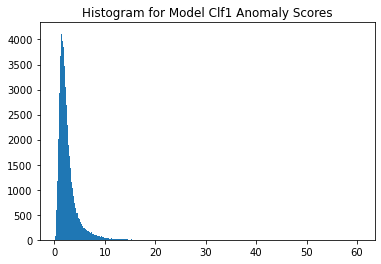

In [76]:
# We can use the histogram to see the threshold
import matplotlib.pyplot as plt
plt.hist(y_clf1_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 10. This means the outlier scores of most of the normal data are less than 10. The outlier scores of the abnormal data are in the high range.

#### Present the descriptive statistics of the normal and the abnormal groups

In [77]:
# Here we used the threshold calculated by the function:
threshold = clf1.threshold_


def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_clf1_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.96,0.99,0.97,0.98,0.99,0.98,1.00,2.22
1,Outlier,8154,5.00046,1.41,1.26,1.33,1.70,1.27,1.60,1.44,1.21,1.35,1.02,8.52


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (8.52 > 2.22). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [78]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_clf1_pred, y_clf1_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


### Model 2

In [79]:
# Selecting necessary features
features2 = df1[features]

In [80]:
clf2 = AutoEncoder(contamination=0.05, hidden_neurons =[10, 2, 10])
clf2.fit(features2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dropout_4 (Dropout)         (None, 10)                0         
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[10, 2, 10],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fba93682280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [81]:
# Hyper-parameter Tunning
clf2.get_params()

{'batch_size': 32,
 'contamination': 0.05,
 'dropout_rate': 0.2,
 'epochs': 100,
 'hidden_activation': 'relu',
 'hidden_neurons': [10, 2, 10],
 'l2_regularizer': 0.1,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 1}

In [82]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_clf2_scores = clf2.decision_function(features2)  # outlier scores
y_clf2_scores = pd.Series(y_clf2_scores)

5096/5096 [==============================] - 3s 682us/step


In [83]:
# Get the prediction on the  data
y_clf2_pred = clf2.predict(features2) 
y_clf2_pred = pd.Series(y_clf2_pred)

5096/5096 [==============================] - 4s 706us/step


#### Determine the threshold

In [84]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , clf2.threshold_)

The threshold for the defined contamination rate: 6.179532618589039


In [85]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_clf2_pred))

The data: {0: 154911, 1: 8154}


In [86]:
y_clf2_pred.value_counts()

0    154911
1      8154
dtype: int64

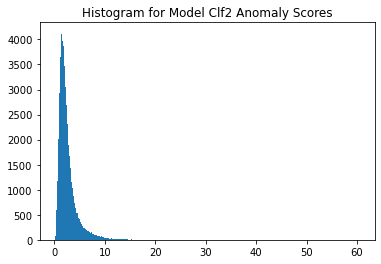

In [87]:
# We can use the histogram to see the threshold
import matplotlib.pyplot as plt
plt.hist(y_clf2_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 10. This means the outlier scores of most of the normal data are less than 10. The outlier scores of the abnormal data are in the high range.

#### Present the descriptive statistics of the normal and the abnormal groups

In [88]:
# Here we used the threshold calculated by the function:
threshold = clf2.threshold_


def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_clf2_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.96,0.99,0.97,0.98,0.99,0.98,1.00,2.22
1,Outlier,8154,5.00046,1.41,1.26,1.33,1.70,1.27,1.60,1.44,1.21,1.35,1.02,8.52


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (8.52 > 2.22). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [89]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_clf2_pred, y_clf2_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


### Model 3

In [90]:
# Selecting necessary features
features2 = df1[features]

In [91]:
clf3 = AutoEncoder(contamination=0.05, hidden_neurons =[10, 5, 2, 5, 10])
clf3.fit(features2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dropout_9 (Dropout)         (None, 10)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                110       
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                110       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                

AutoEncoder(batch_size=32, contamination=0.05, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[10, 5, 2, 5, 10],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7fba93682280>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [92]:
# Hyper-parameter Tunning
clf3.get_params()

{'batch_size': 32,
 'contamination': 0.05,
 'dropout_rate': 0.2,
 'epochs': 100,
 'hidden_activation': 'relu',
 'hidden_neurons': [10, 5, 2, 5, 10],
 'l2_regularizer': 0.1,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 1}

In [93]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_clf3_scores = clf3.decision_function(features2)  # outlier scores
y_clf3_scores = pd.Series(y_clf3_scores)

5096/5096 [==============================] - 4s 687us/step


In [94]:
# Get the prediction on the  data
y_clf3_pred = clf3.predict(features2) 
y_clf3_pred = pd.Series(y_clf3_pred)

5096/5096 [==============================] - 4s 800us/step


#### Determine the threshold

In [95]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , clf3.threshold_)

The threshold for the defined contamination rate: 6.1795921398139315


In [96]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_clf3_pred))

The data: {0: 154911, 1: 8154}


In [97]:
y_clf3_pred.value_counts()

0    154911
1      8154
dtype: int64

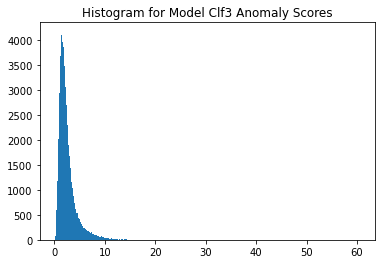

In [98]:
# We can use the histogram to see the threshold
import matplotlib.pyplot as plt
plt.hist(y_clf3_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf3 Anomaly Scores")
plt.show()

The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 10. This means the outlier scores of most of the normal data are less than 10. The outlier scores of the abnormal data are in the high range.

#### Present the descriptive statistics of the normal and the abnormal groups

In [99]:
# Here we used the threshold calculated by the function:
threshold = clf3.threshold_


def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_clf3_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.96,0.99,0.97,0.98,0.99,0.98,1.00,2.22
1,Outlier,8154,5.00046,1.41,1.26,1.33,1.70,1.27,1.60,1.44,1.21,1.35,1.02,8.52


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (8.52 > 2.22). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [100]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_clf3_pred, y_clf3_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


## Achieve Model Stability by Aggregating Multiple Models
* Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
* The solution is to train multiple models then aggregate the scores. 
* I use 2 methods to aggregate the outcome:
* (1) Average: average scores of all detectors.
* (2) Maximum of Maximum (MOM)

In [101]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
features_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

In [102]:
features_scores.head()

,clf1,clf2,clf3
0,2.358167,2.357943,2.358113
1,1.378067,1.378329,1.378309
2,2.258201,2.258280,2.258131
3,1.448041,1.447952,1.447821
4,1.053039,1.053251,1.053232


In [103]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
from pyod.utils.utility import standardizer
features_scores_norm = standardizer(features_scores)

In [104]:
features_scores_norm.shape

(163065, 3)

### Average
The "average" function in PyOD averages the outlier scores from multiple estimators.

In [105]:
# Combination by average
y_by_average = average(features_scores_norm)
y_by_average[1:10]

array([-0.61400198, -0.14779849, -0.57707362, -0.78621794, -0.50908714,
       -0.52442568,  1.69234086,  0.74998483, -0.64130589])

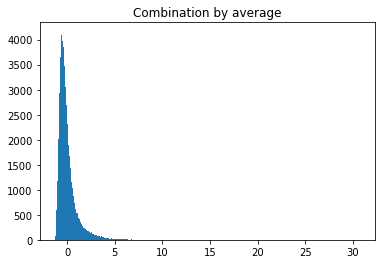

In [106]:
# Let’s plot the histogram for the average of the predictions
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

The histogram suggests 5 for the threshold and it appears we can identify those >=5 as the outliers.

#### Present the descriptive statistics of the normal and the abnormal groups

In [107]:
# We can derive the descriptive statistics with the aggregated score below:
descriptive_stat_threshold(features2,y_by_average,5)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,162448,99.621623,1.00,1.01,1.0,1.00,1.00,1.0,1.00,1.00,1.00,1.00,-0.03
1,Outlier,617,0.378377,1.91,1.55,1.7,2.11,1.39,1.9,1.89,1.38,1.69,1.08,6.67


### Maximum of maximum
Merge the outlier scores from multiple estimators by taking the maximum.

In [108]:
# Combination by max
y_by_maximization = maximization(features_scores_norm)

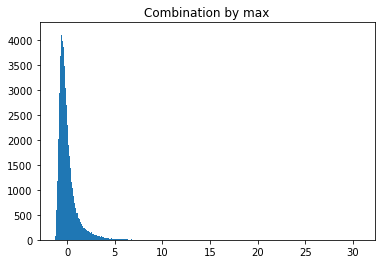

In [109]:
# Let’s plot the histogram for the average of the predictions
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

Similarly, the histogram suggests 5 for the threshold and it appears we can identify those >=5 as the outliers.

#### Present the descriptive statistics of the normal and the abnormal groups

In [110]:
# We can derive the descriptive statistics with the aggregated score below:
descriptive_stat_threshold(features2,y_by_maximization,5)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,162448,99.621623,1.00,1.01,1.0,1.00,1.00,1.0,1.00,1.00,1.00,1.00,-0.03
1,Outlier,617,0.378377,1.91,1.55,1.7,2.11,1.39,1.9,1.89,1.38,1.69,1.08,6.67


## Section 5: Python Outlier Detection (PyOD) IForest - iris <a class="anchor" id="Section_5"></a>

The Isolated Forest algorithm: Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

Most existing model-based approaches to anomaly detection construct a profile of normal instances, then identify instances that do not conform to the normal profile as outliers. But IForest directly and explicitly isolates anomalies. IForest adopts a tree structure to isolate every single data point. Anomalies are the singular data points first to be singled out; whereas normal points tend to cluster together amid the tree.
Because Isolation Forest does not use any distance measures to detect anomalies, it is fast and suitable for large data sizes and high-dimensional problems.

In [111]:
from pyod.models.iforest import IForest

## IForest
* You do not need the target variable to train the unsupervised learning model.
* We will create three models: isft1, isft2,and isft3
* Model 1: max_samples = 100
* Model 2: max_samples = 80
* Model 3: max_samples = 60

### Model 1

In [112]:
# Selecting necessary features
features2 = df1[features]

In [113]:
isft1 = IForest(contamination=0.05, behaviour="new", max_samples=100) 
isft1.fit(features2)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples=100, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [114]:
# Hyper-parameters
isft1.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 100,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

In [115]:
# Variable Importance
isft1_vi = isft1.feature_importances_
isft1_vi

array([0.08336835, 0.09861402, 0.1211669 , 0.11665853, 0.09594525,
       0.08892702, 0.12632458, 0.11480981, 0.08670205, 0.06748348])

<AxesSubplot:>

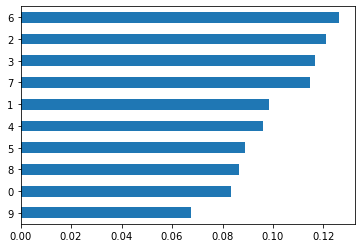

In [116]:
# Plot the feature importance
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':features2.columns,
              'y_axis':isft1_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

In [117]:
y_isft1_scores = isft1.decision_function(features2.values)
y_isft1_pred = isft1.predict(features2.values)

#### Determine the threshold

In [118]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft1.threshold_)

The threshold for the defined contamination rate: -2.453337758097883e-16


In [119]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_isft1_pred))

The data: {0: 154911, 1: 8154}


The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 0.1. This means the outlier scores of most of the normal data are less than 0.1. The outlier scores of the abnormal data are in the high range.

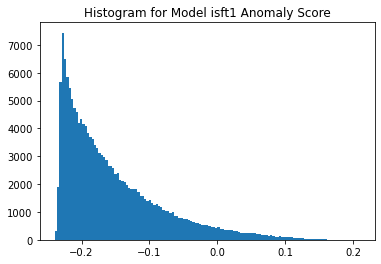

In [120]:
import matplotlib.pyplot as plt
plt.hist(y_isft1_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model isft1 Anomaly Score")
plt.show()

#### Present the Descriptive Statistics of the Normal and the Abnormal groups

In [121]:
threshold = isft1.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_isft1_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.96,0.99,0.97,0.98,0.99,0.98,1.00,-0.16
1,Outlier,8154,5.00046,1.41,1.27,1.33,1.68,1.28,1.59,1.44,1.22,1.36,1.02,0.05


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (0.05 > -0.16). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [122]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_isft1_pred, y_isft1_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


### Model 2

In [123]:
# Selecting necessary features
features2 = df1[features]

In [124]:
isft2 = IForest(contamination=0.05, behaviour="new", max_samples=80) 
isft2.fit(features2)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples=80, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [125]:
# Hyper-parameters
isft2.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 80,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

In [126]:
# Variable Importance
isft2_vi = isft2.feature_importances_
isft2_vi

array([0.11599904, 0.08055834, 0.09710575, 0.10842713, 0.10390968,
       0.11292539, 0.10359835, 0.08379774, 0.10065589, 0.09302269])

<AxesSubplot:>

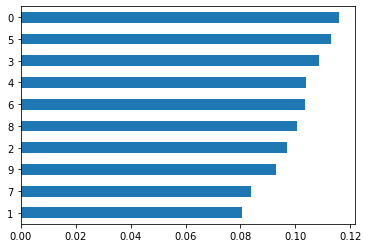

In [127]:
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':features2.columns,
              'y_axis':isft2_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

In [128]:
y_isft2_scores = isft2.decision_function(features2.values)
y_isft2_pred = isft2.predict(features2.values)

#### Determine the threshold

In [129]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft2.threshold_)

The threshold for the defined contamination rate: -1.0673292761761988e-16


In [130]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_isft2_pred))

The data: {0: 154911, 1: 8154}



The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 0.1. This means the outlier scores of most of the normal data are less than 0.1. The outlier scores of the abnormal data are in the high range.

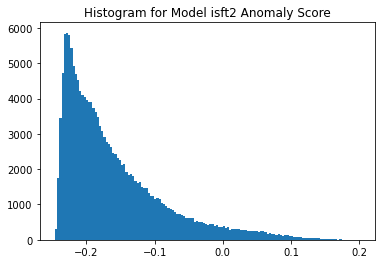

In [131]:
import matplotlib.pyplot as plt
plt.hist(y_isft2_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model isft2 Anomaly Score")
plt.show()

#### Present the Descriptive Statistics of the Normal and the Abnormal groups

In [132]:
threshold = isft2.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_isft2_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.97,0.99,0.97,0.98,0.99,0.98,1.00,-0.17
1,Outlier,8154,5.00046,1.43,1.27,1.35,1.56,1.21,1.50,1.47,1.22,1.37,1.02,0.05


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (0.05 > -0.17). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [133]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_isft2_pred, y_isft2_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


### Model 3

In [134]:
# Selecting necessary features
features2 = df1[features]

In [135]:
isft3 = IForest(contamination=0.05, behaviour="new", max_samples=60) 
isft3.fit(features2)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples=60, n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [136]:
# Hyper-parameters
isft3.get_params()

{'behaviour': 'new',
 'bootstrap': False,
 'contamination': 0.05,
 'max_features': 1.0,
 'max_samples': 60,
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': None,
 'verbose': 0}

In [137]:
# Variable Importance
isft3_vi = isft3.feature_importances_
isft3_vi

array([0.106247  , 0.08975626, 0.12422723, 0.10151213, 0.11000411,
       0.09412229, 0.10819995, 0.09182162, 0.10208006, 0.07202935])

<AxesSubplot:>

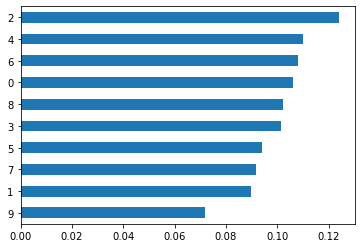

In [138]:
from matplotlib import pyplot as plt
for_plot = pd.DataFrame({'x_axis':features2.columns,
              'y_axis':isft3_vi}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

In [139]:
y_isft3_scores = isft3.decision_function(features2.values)
y_isft3_pred = isft3.predict(features2.values)

#### Determine the threshold

In [140]:
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , isft3.threshold_)

The threshold for the defined contamination rate: -2.6550300671245248e-17


In [141]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The data:", count_stat(y_isft3_pred))

The data: {0: 154911, 1: 8154}




The threshold is to be determined by the histogram of the outlier scores. The chart below suggests a threshold around 0.1. This means the outlier scores of most of the normal data are less than 0.1. The outlier scores of the abnormal data are in the high range.

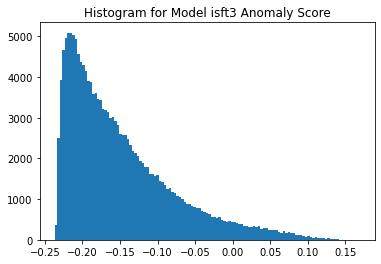

In [142]:
import matplotlib.pyplot as plt
plt.hist(y_isft3_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model isft3 Anomaly Score")
plt.show()

#### Present the Descriptive Statistics of the Normal and the Abnormal groups

In [143]:
threshold = isft3.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(features2,y_isft3_scores, threshold)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,154911,94.99954,0.98,1.00,0.98,0.97,0.99,0.97,0.98,0.99,0.98,1.00,-0.16
1,Outlier,8154,5.00046,1.43,1.29,1.35,1.64,1.26,1.57,1.47,1.25,1.38,1.03,0.04


The table presents the characteristics of the normal and abnormal groups. It shows the count and count percentage of the normal and outlier groups. 

- The size of the outlier group: The outlier group is about 5%. Remember the size of the outlier group is determined by the threshold. The size will shrink if you choose a higher value for the threshold.
- The average anomaly score: The average outlier score of the outlier group is far higher than that of the normal group (0.04 > -0.16). This evidence just verifies the data in the outlier group are outliers. At this point, you do not need to interpret too much on the scores.
- The feature statistics in each group: The means of the features in the outlier group are larger than those of the normal group. A high average ratio of payment/discharges features, that is more than the average values, could suggest fraudulent behaviour.

#### Evaluate the model performance

The confusion matrix proves the model does a decent job and identifies all 8154 outliers.

In [144]:
# Confusion Matrix
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_isft3_pred, y_isft3_scores,threshold)

Pred,0,1
Actual,,
0,154911,0
1,0,8154


## Achieve Model Stability by Aggregating Multiple Models
* Unsupervised techniques can detect many outliers. But due to its unspervised nature it is not stable, meaning overfitting to a specific dataset.
* The solution is to train multiple models then aggregate the scores. 
* I use two methods to aggregate the outcome:
* (1) Average: average scores of all detectors.
* (2) Maximum of Maximum (MOM)

In [145]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

In [146]:
# Selecting necessary features
features2 = df1[features]

In [147]:
# The predictions of the training data can be obtained by isft.decision_scores_.
# It is already generated during the model building process.
features_scores = pd.DataFrame({'isft1': isft1.decision_scores_,
                             'isft2': isft2.decision_scores_,
                             'isft3': isft3.decision_scores_
                            })

In [148]:
features_scores.head()

,isft1,isft2,isft3
0,-0.147743,-0.171608,-0.126133
1,-0.215691,-0.217350,-0.206951
2,-0.174731,-0.150023,-0.159265
3,-0.197063,-0.204301,-0.203877
4,-0.228279,-0.231278,-0.225695


To produce a stable prediction outcome, we can aggregate the scores produced by multiple models. Of all the hyper-parameters, the number of trees n_estimators probably is the most important one. I am going to produce 5 models for a range of the number of trees. The average prediction of these models will be the final model prediction.

In [149]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
features_scores_norm = standardizer(features_scores)

In [150]:
# Test a range of the number of trees
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
y_iforest_scores = np.zeros([features2.shape[0], n_clf])

In [151]:
# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k) 
    isft = IForest(contamination=0.05, n_estimators=k) 
    isft.fit(features2.values)
    
    # Store the results in each column:
    y_iforest_scores[:, i] = isft.decision_function(features2.values) 
    
# Decision scores have to be normalized before combination
y_scores_norm = standardizer(y_iforest_scores)

### Average
The "average" function in PyOD averages the outlier scores from multiple estimators.

In [152]:
# Combination by average
y_average = average(y_scores_norm)

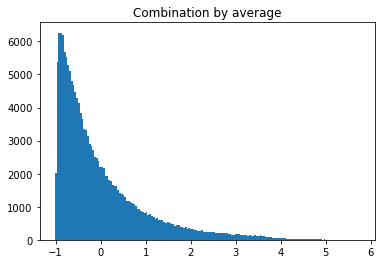

In [153]:
import matplotlib.pyplot as plt
plt.hist(y_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

The histogram suggests 3 for the threshold and it appears we can identify those >=3 as the outliers.

#### Present the descriptive statistics of the normal and the abnormal groups

In [154]:
# Let's profile the characteristics of the normal and the outlier groups 
descriptive_stat_threshold(features2,y_average, 3)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,159549,97.843805,0.99,1.00,0.99,0.98,0.99,0.99,0.99,0.99,0.99,1.00,-0.08
1,Outlier,3516,2.156195,1.55,1.37,1.44,1.75,1.34,1.67,1.59,1.30,1.48,1.04,3.60


### Maximum of maximum

In [155]:
# Combination by max
y_by_maximization = maximization(y_scores_norm)

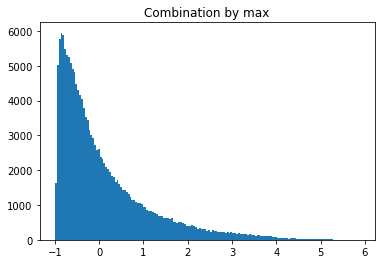

In [156]:
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

The histogram suggests 3 for the threshold and it appears we can identify those >=3 as the outliers.

#### Present the descriptive statistics of the normal and the abnormal groups

In [157]:
# Let's profile the characteristics of the normal and the outlier groups 
descriptive_stat_threshold(features2,y_by_maximization, 3)

,Group,Count,Count %,Avg_Payment_ByStateDRG_ratio_amount,Average_Payment_ByCityDRG_ratio_amount,Avg_Payment_ByRegionDRG_ratio_amount,Avg_Discharges_ByStateDRG_ratio_amount,Avg_Discharges_ByCityDRG_ratio_amount,Avg_Discharges_ByRegionDRG_ratio_amount,Avg_Medicare_ByStateDRG_ratio_amount,Avg_Medicare_ByCityDRG_ratio_amount,Avg_Medicare_ByRegionDRG_ratio_amount,Avg_Medicare_ByZipDRG_ratio_amount,Anomaly_Score
0,Normal,158881,97.434152,0.99,1.00,0.99,0.98,0.99,0.98,0.99,0.99,0.99,1.00,-0.00
1,Outlier,4184,2.565848,1.51,1.34,1.41,1.75,1.34,1.67,1.55,1.28,1.44,1.04,3.66
